# Bayesian Mixed-Media Model - Joao Semeano



### List of contents

0 - necessary libraries

1 - DATA<br>
1.1 - data exploration<br>
1.2 - data standardization<br>

2 - MODELLING<br>
2.1 - Adstock transformation<br>
2.2 - Trend and seasonality<br>
2.3 - Model<br>

3 - RESULTS<br>
3.1 - Model performance<br>
3.2 - Trend and seasonality parameters<br>
3.3 - Channel performance / Return on Investment<br>

## 0 - necessary libraries

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xarray as xr
from statsmodels.tsa.filters import hp_filter
import itertools

In [2]:
import matplotlib.style as style
style.use('seaborn-v0_8-whitegrid')


# 1 - DATA

## 1.1 - data exploration

In [3]:
# reading the data

data = pd.read_csv(
  'MMM_test_data.csv',
    delimiter = ';',
  parse_dates=['start_of_week'],
  index_col='start_of_week',
)


C:\Users\jseme\AppData\Local\Temp\ipykernel_16864\2602530092.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data = pd.read_csv(


In [4]:
data.describe()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,136490.190673,1245.604808,343.640962,19507.177981,6915.136731,8575.611442,5063.699038,27701.367404
std,50810.253012,1388.384632,332.988218,8714.759886,3123.172035,6956.787524,6689.472660,12176.293684
min,63207.090000,0.000000,4.370000,5938.130000,3602.200000,747.460000,0.000000,9391.210000
25%,101675.685000,334.275000,120.470000,13879.000000,5113.937500,2902.032500,0.000000,19797.710000
50%,128790.460000,856.870000,202.020000,17929.450000,6194.400000,6879.270000,2423.095000,24248.640000
75%,157707.280000,1658.032500,553.075000,22252.262500,7470.557500,14367.582500,8701.960000,33852.652500
max,418186.380000,8513.830000,1605.850000,49689.380000,22629.690000,33009.650000,33692.830000,77488.420000


### comments
- balanced dataset
- channels 1 and 6 go all the way down to 0. (6 is at 0 25% of the time)


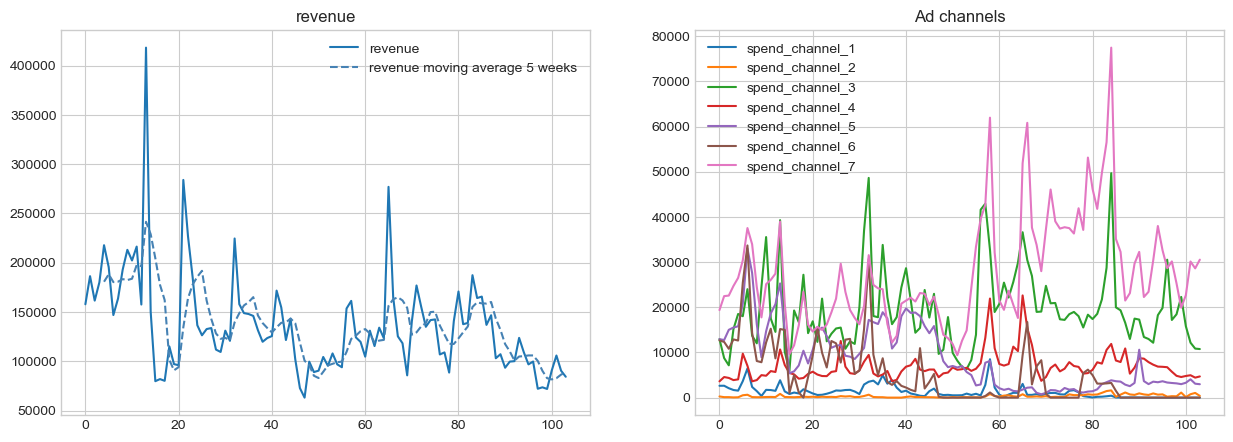

In [5]:
# ploting the series
window_size = 5
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(data['revenue'].values,  label='revenue')
axs[0].plot(data['revenue'].rolling(window=window_size).mean().values,  label='revenue moving average 5 weeks', color='steelblue', linestyle='--')
axs[0].set(title='revenue')
axs[0].legend()
axs[1].plot(data.filter(regex='^spend_channel').values,  label=data.filter(regex ='^spend' ).columns)
axs[1].set(title = 'Ad channels')
axs[1].legend()

### comments
- revenue has a downwards trend
- it's possible to identify some seasonality in the revenue, namelly spikes at the end of each year (Christmas?)
- there are huge differences between the amount spent in the many different channels, with channel 3 and 7 being clearly the most expensive

<Axes: title={'center': 'revenue trend'}, xlabel='start_of_week'>

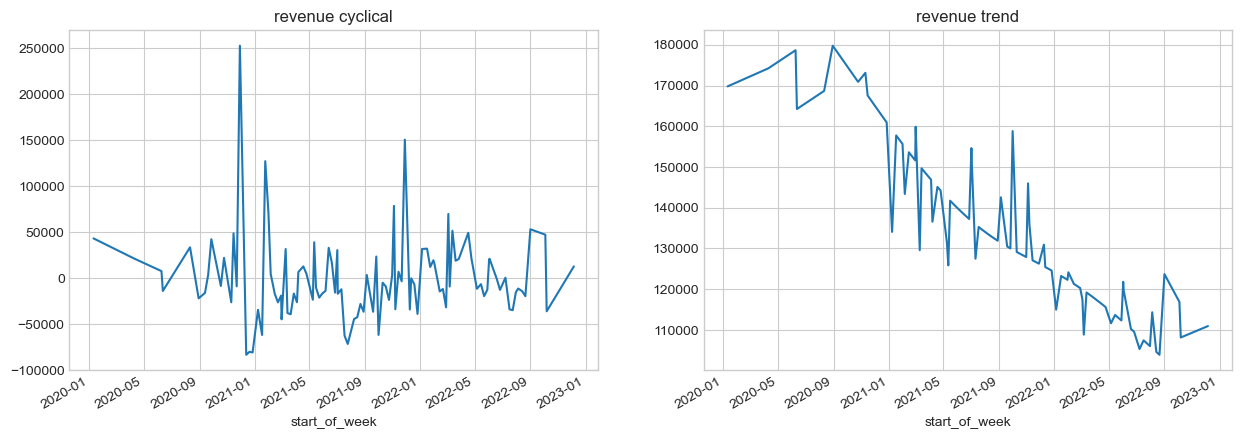

In [6]:
# let's have a look at the cyclical and trend components of revenue using a simple HP filter

rev_cyclical = hp_filter.hpfilter(data['revenue'], lamb=1600 * 124)[0]
rev_trend = hp_filter.hpfilter(data['revenue'], lamb=1600 * 124)[1]


fig, axs = plt.subplots(1, 2, figsize=(15,5))

rev_cyclical.plot.line( ax=axs[0], title = 'revenue cyclical')
rev_trend.plot.line( ax=axs[1], title = 'revenue trend')

### comments
- the cyclical factors are more relevant than the trend (varying between -100000 and 250000)
- the trend is clearly decreasing but at a relatively small rate (about 730 per week)
- crucially, the HP filter with the typical lambda for weekly data, does not provide a smooth trend. This can be due to either a volatile underlying process or outliers

## 1.2 - data standardization

- in order to maintain the Rhat statistics and to be able to set the channels to zero during the ROI calculation, the data will be standardized with the absolute value and then add an infinitesimal quantity

In [7]:
# function to scale the series

scaler_params = dict()

def MaxAbs_scaler(x):
    scaler_params[x.name] = {
        'max' : max(abs(x)),
    }

    return (x )/(max(abs(x))) + 0.000001

In [8]:
data_stand = data.apply(MaxAbs_scaler, axis = 0)

<Axes: >

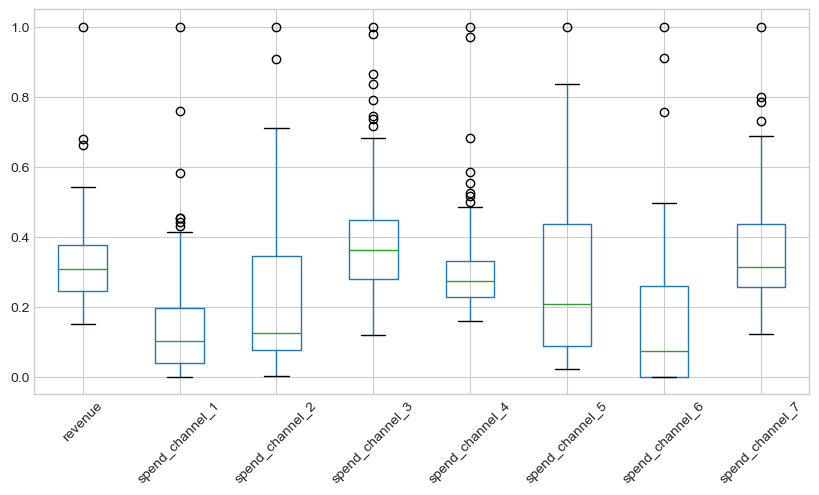

In [9]:
#boxplot of the scaled series
data_stand.boxplot(figsize = (10,5), rot= 45)

### comments
- all series (but especially channels 2, 5 and 6) skewed to top values, suggesting long periods of low investment with punctual increases

<Axes: >

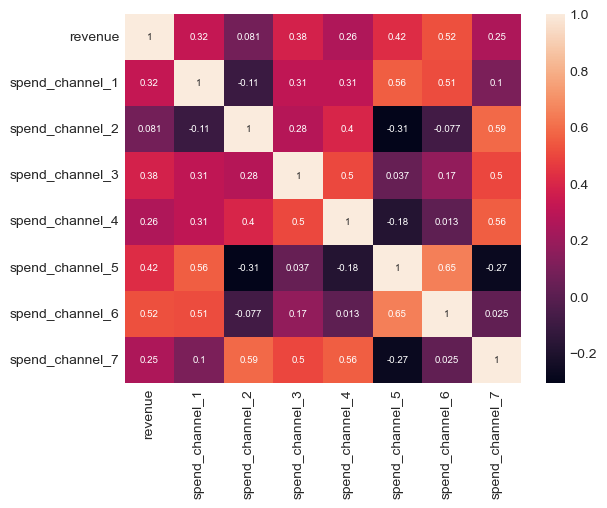

In [10]:
# plotting the correlation matrix

corr_mat = data_stand.corr();
sns.heatmap(corr_mat, annot=True, annot_kws={"size": 7})

### comments
- all channels are positively contemporaneously correlated with revenue (at least ensuring we aren't paying for bad publicity :) )
- channel 6 and to a lesser extent 5 are highly contemporaneously correlated with revenue. these 2 are also highly correlated among themselves

In [11]:
X = data_stand.drop(columns=['revenue'])
y = data_stand['revenue']

# 2 - MODELLING

## 2.1 - adstock transformation

- following the [paper by Jin and Wang](https://research.google/pubs/pub46001/), carryover (adstock) effects was modeleled with geometric decay
- there are 2 parameters in this transformation. alpha, for the loss and L for the maximum duration of ad effect
- whereas both could be estimated, L will be set 12 as suggested in the paper
- using the pytensor library allows us to create an object that will be updated during the fitting (adstock function), but it would be good to have a look at the effects of the transformation (adstock_chart function)

In [12]:
# function to chart the adstock
def adstock_chart(series, alpha=.1, L=12):
    
    adstock_series = series[:L].to_list()
    
    alpha_chain = [alpha**l for l in range(L)]
    alpha_chain.reverse()
    
    adstock_series = adstock_series + [np.dot(series[l-L:l],alpha_chain) for l in range(L,len(series))]
    
    alpha_chain.reverse()

    return adstock_series, alpha_chain

In [13]:
# some adstock examples with different alpha and L

adstock_examples = {}

for alpha, L in zip([0.1, 0.1 , 0.5, 0.5], [12, 5 ,12, 5]):
    
    adstock_series, alpha_chain  = adstock_chart(X['spend_channel_1'], alpha=alpha, L=L)
    
    adstock_examples[f'alpha:{alpha}/L:{L}'] = {'adstock_series' : adstock_series,
                                               'alpha_chain' : alpha_chain}
    
adstock_examples_df = pd.DataFrame(data = adstock_examples)

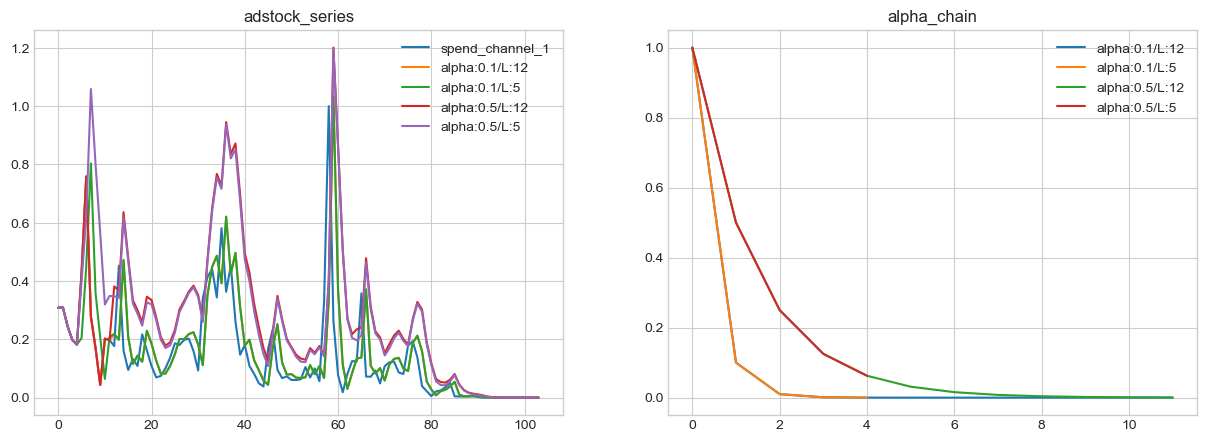

In [14]:
# plotting the examples

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(X['spend_channel_1'].values,  label='spend_channel_1')

for alpha_L_example in adstock_examples_df.columns:

    axs[0].plot(adstock_examples_df.loc['adstock_series', alpha_L_example],  label=alpha_L_example)
    axs[0].set(title='adstock_series')
    axs[0].legend()
    axs[1].plot(adstock_examples_df.loc['alpha_chain', alpha_L_example],  label=alpha_L_example)
    axs[1].set(title = 'alpha_chain')
    axs[1].legend()

### comments
- as we can see, increasing the alpha spikes the effects of the spending due to a slower tapering
- similarly, if we increase L, we allow the effects to linger for longer
- all in all, the alpha parameters seems more relevant than L

In [15]:
def adstock(x, alpha, length=12):
    w = tt.as_tensor_variable(
        [tt.power(alpha, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w / tt.sum(w), x_lags)

## 2.2 - trend and seasonality
- As discussed in the data exploration, there are clear signs of trend and seasonality affecting the revenues
- trend and seasonality modeling followed the approach from [Taylor and Lentham](https://peerj.com/preprints/3190/)

In [16]:
# time series for the trend
t = np.linspace(1,len(X['spend_channel_1']),len(X['spend_channel_1']))


In [17]:
# adding a week count to the dataframe
period_series = []

for i, row in data_stand.iterrows():
    period_series.append(pd.Period(i, freq='W').week)
    
data_stand['week'] = period_series

In [18]:
# creating the fourier modes for the seasonality
# note: tried with orders 3, 5 and 7 as the sources diverged in what parameter to use. since there weren't any material differences, the simplest one was chosen

n_order = 3
periods = data_stand["week"] / 52.1775 
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

In [19]:
var_list = X.columns
date = X['spend_channel_1'].index.values# data_stand['week']# X['spend_channel_1'].index.values

## 2.3 - Model
- setting up the bayesian model

In [20]:
# the following is the model specification with comments about the choices made

# definition of the coordinates to apply the trend and seasonal components
coords = {
    "date": X['spend_channel_1'].index.to_numpy(), 
    "fourier_mode": np.arange(2 * n_order)
}

with pm.Model(coords=coords) as mmm:
    # --- coords ---
    mmm.add_coord(name="dat", values=date, mutable=True)
    mmm.add_coord(name="fourier_mode", values=np.arange(2 * n_order), mutable=False)
    
    # -- base value --
    # the revenue at time 0 is surely positive, so an exponential prior was chosen
    base = pm.Exponential('base', lam=0.0001)
    
    # --- trend ---
    # as discussed, the trend is negative, so attributing a normal distribution is a good choice as it allows for values below 0  
    # sigma = 2 means is a rather unrestrictive prior
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    trend = pm.Deterministic(name="trend", var=b_trend * t, dims="date")
    
    # --- seasonality --- 
    # following the paper from Taylor and Lentham, a normal prior is imposed to provide for positive or negative values
    b_fourier = pm.Normal(name="b_fourier", mu=0, sigma=2, dims="fourier_mode")
      
    # multiplying the fourier features by the coefficients for each feature will give us the full seasonality effect
    seasonality = pm.Deterministic(
        name="seasonality", var=pm.math.dot(fourier_features, b_fourier), 
        dims="date"
    )
    
    
    # --- channel contributions ---
    # the contribution for each spending channel is computed separately and added to a channel_contributions list
    # for simplicity, the same priors for each channel were imposed, however, it is very possible that the channels are different enough to warrant different initial parameters
    
    channel_contributions = []
    
    for channel in var_list:
        
        # assuming that the effects of every channel are positive, an exponential prior is imposed
        coef = pm.Exponential(f'coef_{channel}', lam=0.001)


        # Assuming the carryover is also between 0 and 1, a beta prior is imposed. It restricts the maximum and minimum value but allows to different shapes
        alpha = pm.Beta(f'alpha_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        
        # --- data containers ---
        # creating this MutableData object will allow me to later set the values to zero and thus compute ROI
        channel_data_ = pm.MutableData(name=f"{channel}_data", value=channel_data, dims="date")

        # composition of the total contribution for each channel
        # the total contribution is the coef multiplied by the total carryover for the channel
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef *  adstock(
                    channel_data_,
                    alpha
                ), dims="date"
        )
        
        channel_contributions.append(channel_contribution)
        

    # the average of the revenue will be defined by the sum of the base, the contribution of the 7 channels (after adstock), the trend and the seasonality  
    mu = pm.Deterministic(name="mu", var=base + sum(channel_contributions) + trend + seasonality, dims="date")

    # --- noise ---
    # the variation around the mean needs to be positive, hence the exponential distribution
    noise = pm.Exponential('noise', lam=1)
    
    sales = pm.Normal(
        'sales',
        mu=mu,
        sigma=noise,
        observed=y, 
        dims="date"
    )
    
    # I will discard the first 10000 draws as tuning, then accept the following 10000 draws to build the trace
    # the target_accept was raised to 0.95 to prevent divergent chains
    
    trace = pm.sample(10000, 
                      return_inferencedata=True, 
                      tune=10000, 
                      cores= None, 
                      target_accept=0.95
                     )

    # finally, posterior distributions will be calculated
    post_checks = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [base, b_trend, b_fourier, coef_spend_channel_1, alpha_spend_channel_1, coef_spend_channel_2, alpha_spend_channel_2, coef_spend_channel_3, alpha_spend_channel_3, coef_spend_channel_4, alpha_spend_channel_4, coef_spend_channel_5, alpha_spend_channel_5, coef_spend_channel_6, alpha_spend_channel_6, coef_spend_channel_7, alpha_spend_channel_7, noise]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 2035 seconds.
Sampling: [sales]


In [21]:

var_names = []
for channel in var_list:
    var_names.append(f'coef_{channel}')
    var_names.append(f'alpha_{channel}')
    
az.summary(
    data=trace,
    var_names=["base", "b_trend", "b_fourier", "noise"] + var_names,
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
base,0.167,0.051,0.067,0.261,0.000,0.000,20217.0,14781.0,1.0
b_trend,-0.002,0.001,-0.003,-0.001,0.000,0.000,21616.0,24196.0,1.0
b_fourier[0],-0.001,0.014,-0.028,0.025,0.000,0.000,60228.0,28510.0,1.0
b_fourier[1],0.008,0.015,-0.021,0.035,0.000,0.000,47937.0,30827.0,1.0
b_fourier[2],0.009,0.015,-0.020,0.037,0.000,0.000,44793.0,29627.0,1.0
b_fourier[3],0.016,0.015,-0.013,0.043,0.000,0.000,54624.0,29833.0,1.0
b_fourier[4],0.005,0.014,-0.022,0.032,0.000,0.000,51618.0,30526.0,1.0
b_fourier[5],0.019,0.014,-0.007,0.047,0.000,0.000,54051.0,30160.0,1.0
noise,0.097,0.007,0.083,0.111,0.000,0.000,46737.0,28274.0,1.0
coef_spend_channel_1,0.050,0.050,0.000,0.138,0.000,0.000,37703.0,21820.0,1.0


### comments
- the model was successfully sampled displaying 0 divergences
- R_hat (Gelman-Rubin statistic) is close to 1 for all parameters

# 3 - RESULTS

## 3.1 - Model performance
- to gauge model performance 2 methods will be used:<br>
-- charting the path implied by the model posterior<br>
-- checking the posterior distribution versus the data distribution<br>
- a further check could be done by dividing the data into test and training sets; and then applying the distributions learnt in the training set to the data in the test set. This would give us important information about overfitting, especially if this model is to be used for forecasting

In [22]:
# extract the posterior path and rescale it

posterior_predictive_likelihood = az.extract(
    data=post_checks,
    group="posterior_predictive",
    var_names="sales",
)

post_pred_likelihood_mean = posterior_predictive_likelihood.values.mean(1)*scaler_params['revenue']['max']
post_pred_likelihood_std = posterior_predictive_likelihood.values.std(1)*scaler_params['revenue']['max']


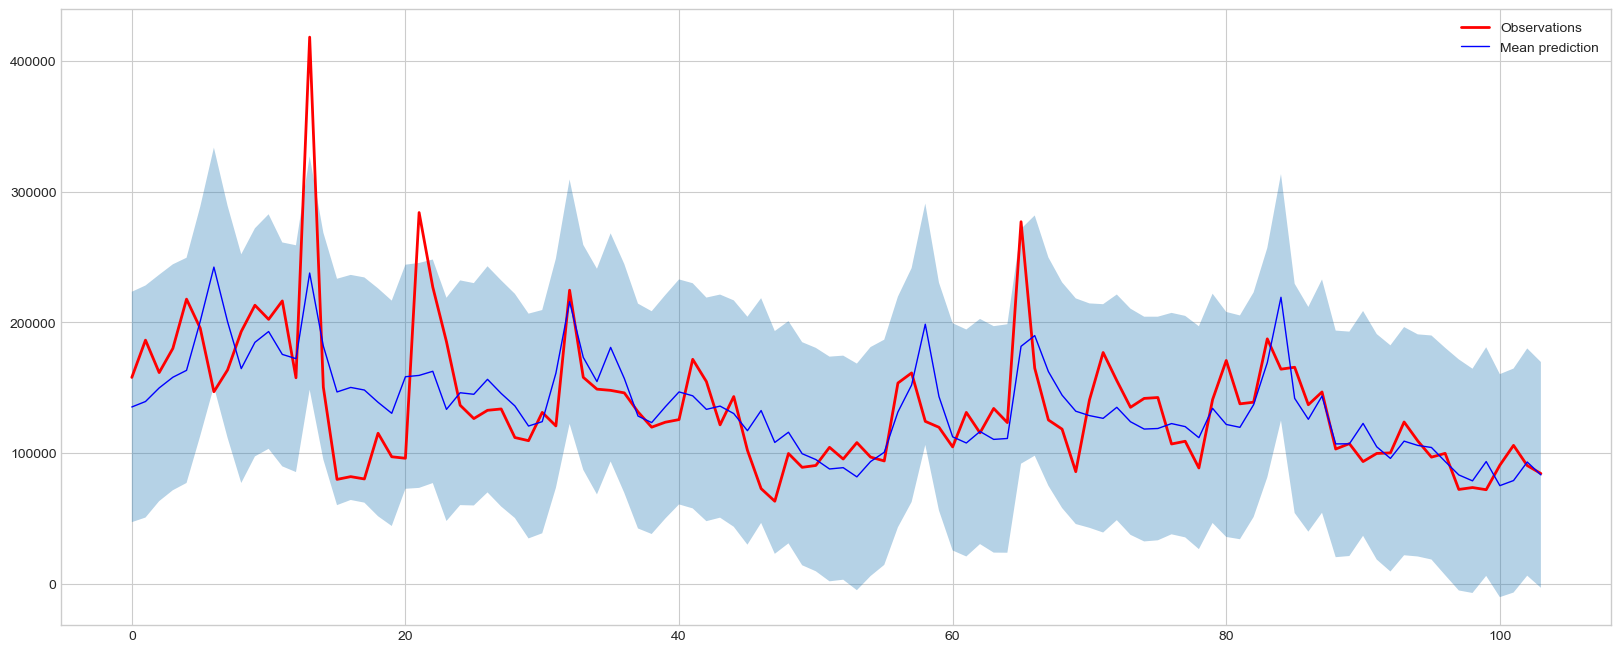

In [23]:
# plotting posterior path

plt.figure(figsize=(20, 8))
plt.plot(data['revenue'].values, linewidth=2, c='r', label='Observations')
plt.plot(post_pred_likelihood_mean, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(data['revenue'])), post_pred_likelihood_mean - 2*post_pred_likelihood_std, post_pred_likelihood_mean + 2*post_pred_likelihood_std, alpha=0.33)
plt.legend()

### comments
- all in all the model captures the main movements of the data
- only very extreme observations lie outside 2 standard deviations of the prediction model

<Axes: xlabel='sales / sales'>

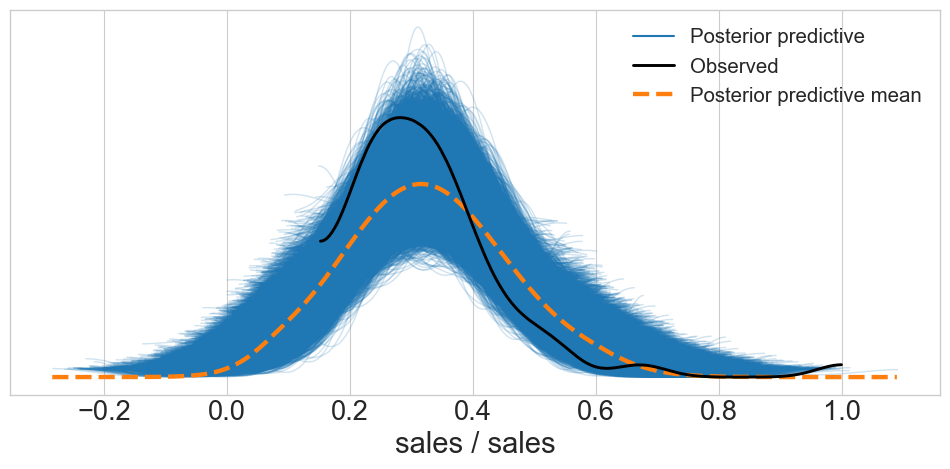

In [24]:
# plotting the posterior distribution
az.plot_ppc(post_checks,  figsize=(12, 5))

### comments
- the posterior distribution implied in the data and the model are quite far apart, suggesting there is room for improving the model. For example, trying further priors and starting parameters could be helpful

## 3.2 - Base, trend and seasonality Parameters


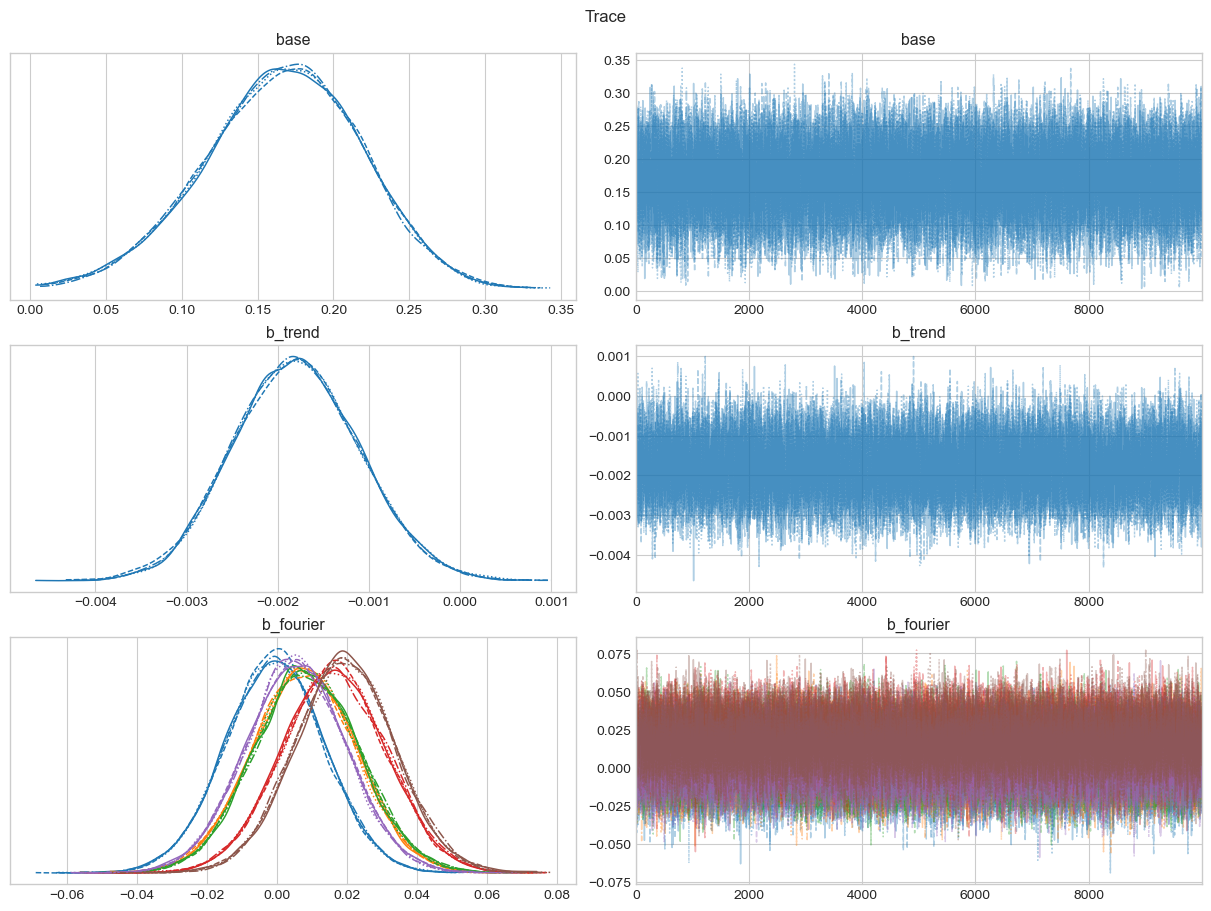

In [25]:
axes = az.plot_trace(
    data=trace,
    var_names=["base", "b_trend", "b_fourier"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Trace");

### comments
- as expected, the base (value at time 0) is positive and the trend term is negative
- the 6 fourier terms (3 modes for sin and 3 for cos) are mostly positive
- in the right column we see the sampled values. these don't display any particular shape and rather look like white noise. A good sign of the health of the model

## 3.3 - Channel performance / Return on Investment

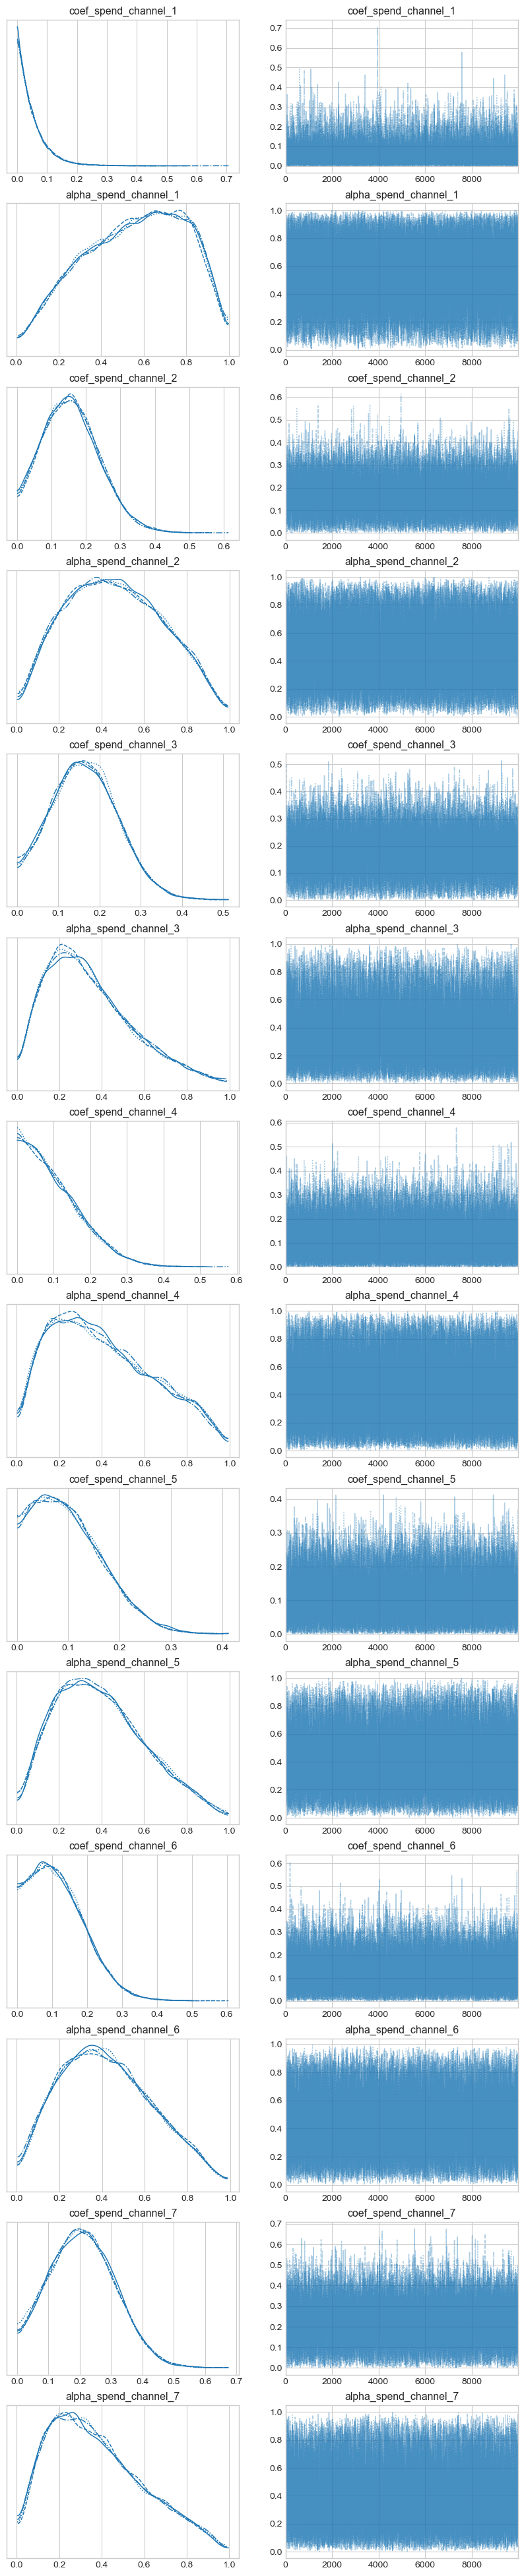

In [26]:
# plotting the posterior distribution of the spend channels (coefficient and alpha) and the sampled values shows that we have healthy posterior distributions


axes = az.plot_trace(
    data=trace,
    var_names=var_names,
    compact=True,
    backend_kwargs={
        "figsize": (10, 50),
    },
)
fig = axes[0][0].get_figure()

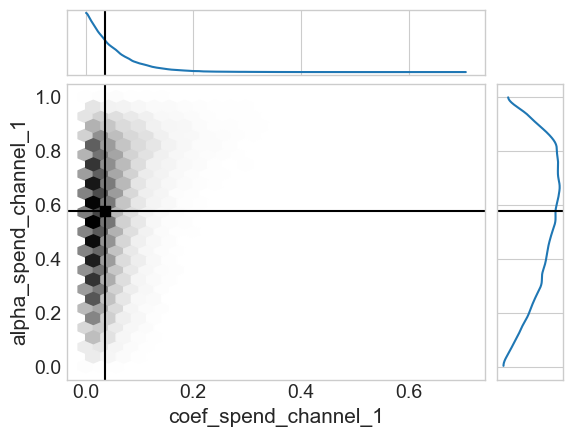

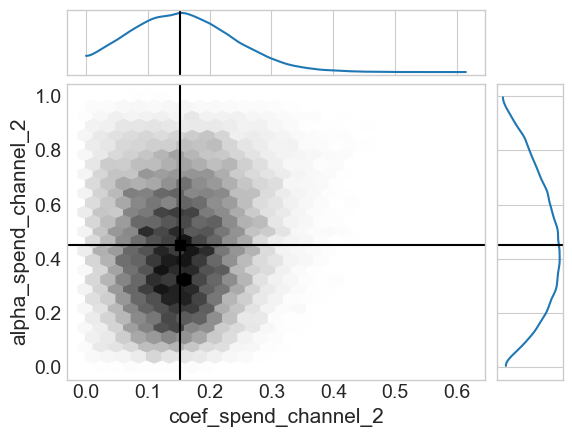

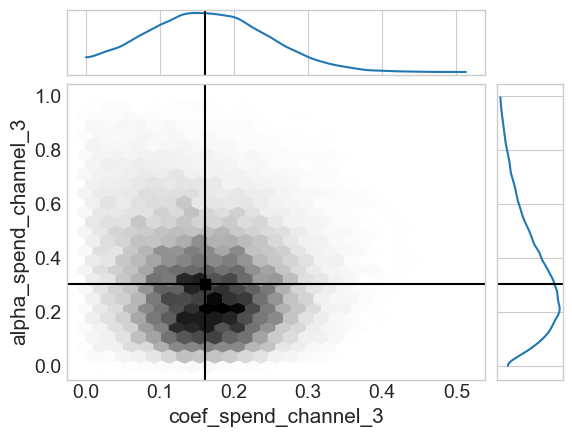

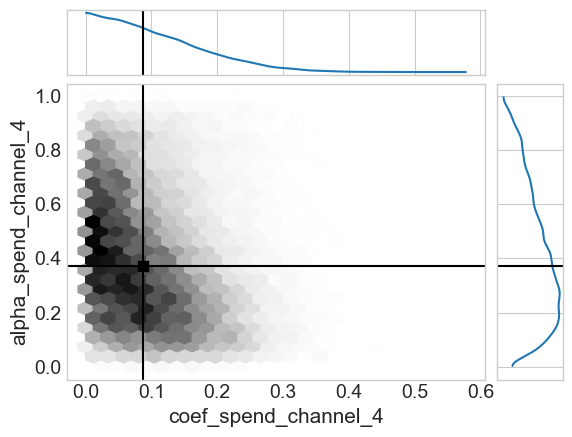

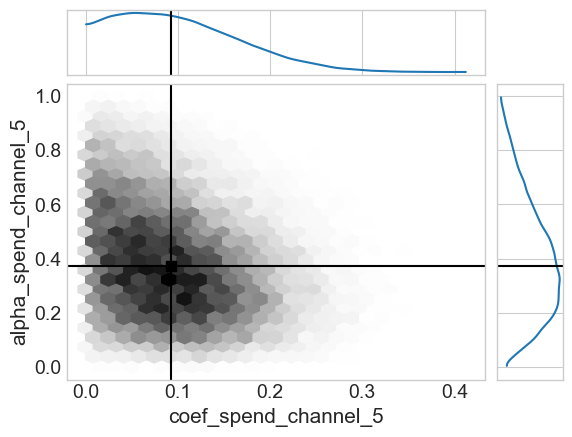

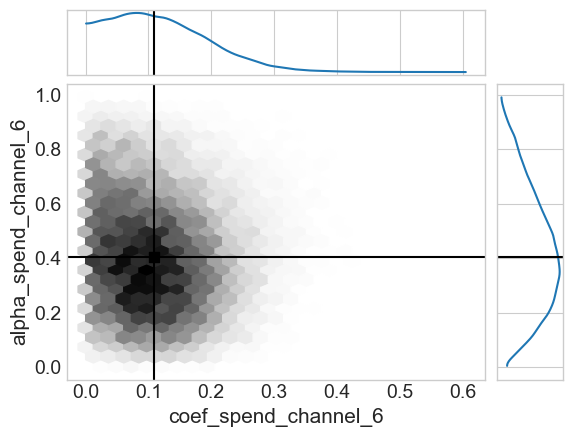

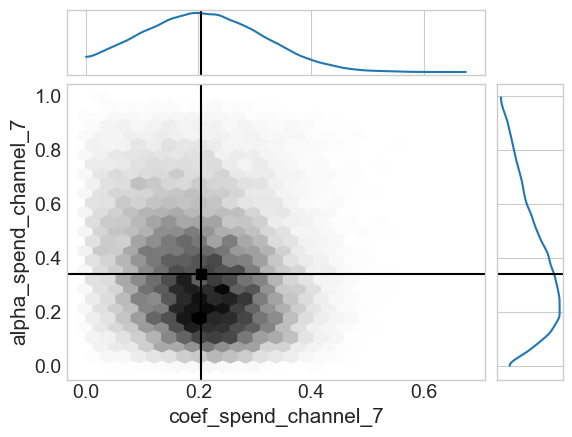

In [27]:
# plotting the coefficient versus the adstock alpha to have an overview of the effect of each channel


for i, channel in enumerate(var_list):
    az.plot_pair(
        trace,
        var_names=[f'coef_{channel}', f'alpha_{channel}'],
        kind="hexbin",
        marginals=True,
        point_estimate = 'median'
    )    
    

### comments
- Channel 1: largest permanence through adstock, lowest coefficient
- Channel 2: very high permanence, second highest coefficient
- Channel 3: lowest permanence, third highest coefficient
- Channel 4: low permanence, second lowed coefficient
- Channel 5: similar to channel 4, but with a better coefficient distribution
- Channel 6: good permanence, but relatively small coefficient
- Channel 7: highest coefficient, but rather low permanence

from the points written above, these are the main findings about the channels:<br>
Channels 4, 5 and 6 have similar performances, with channel 6 being the best of these 3, due to an alpha distribution tilted to higher values.<br>
Channels 3 and 7 have the best coefficients but low permanence through adstock. We could consider increasing the investment here.<br>
Channel 2 seems to work well due to a large coefficient but already has the largest permanence, perhaps there’s no need to invest more.<br>
Channel 1 seems to have very low impact and a very large permanence, we should either consider it underperforming or invest in it decisively but sparsely.<br>


Sampling: [sales]


Sampling: [sales]


Sampling: [sales]


Sampling: [sales]


Sampling: [sales]


Sampling: [sales]


Sampling: [sales]


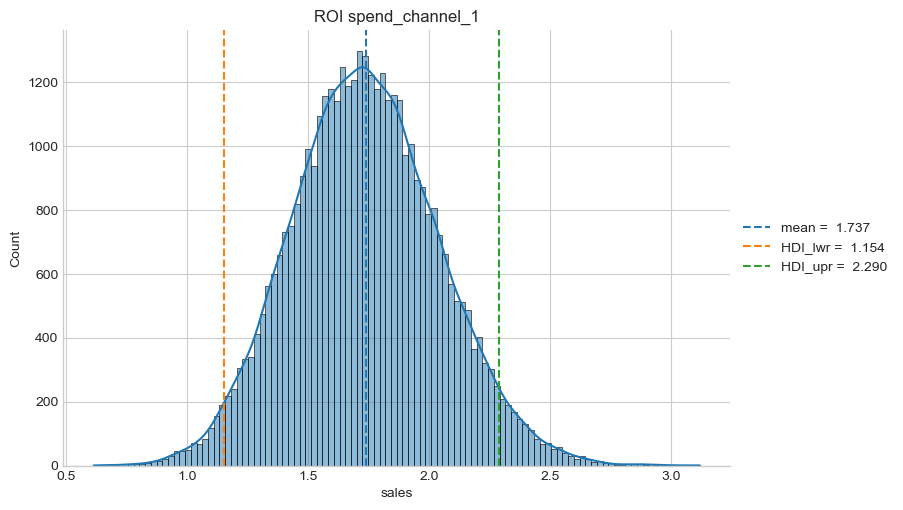

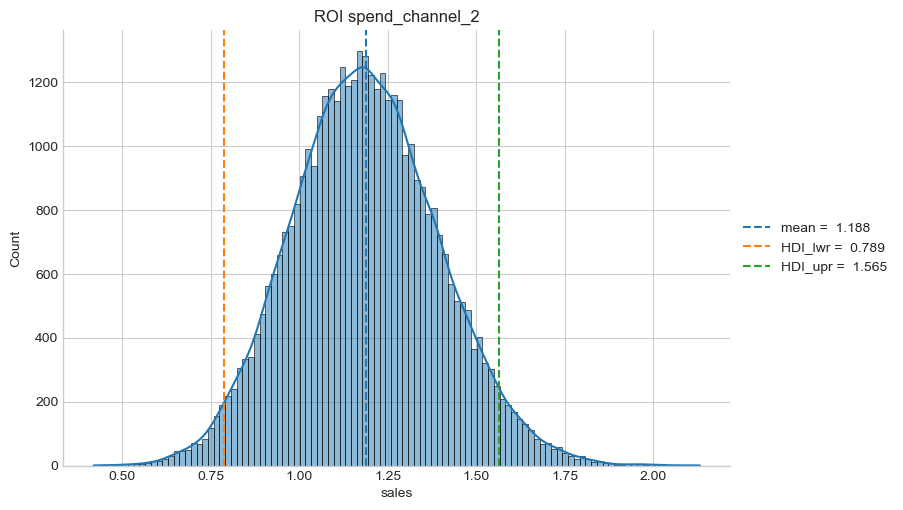

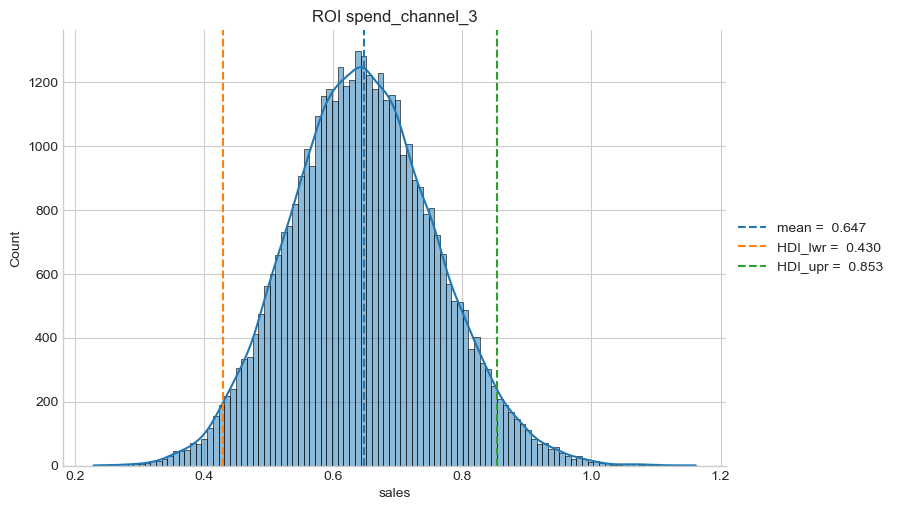

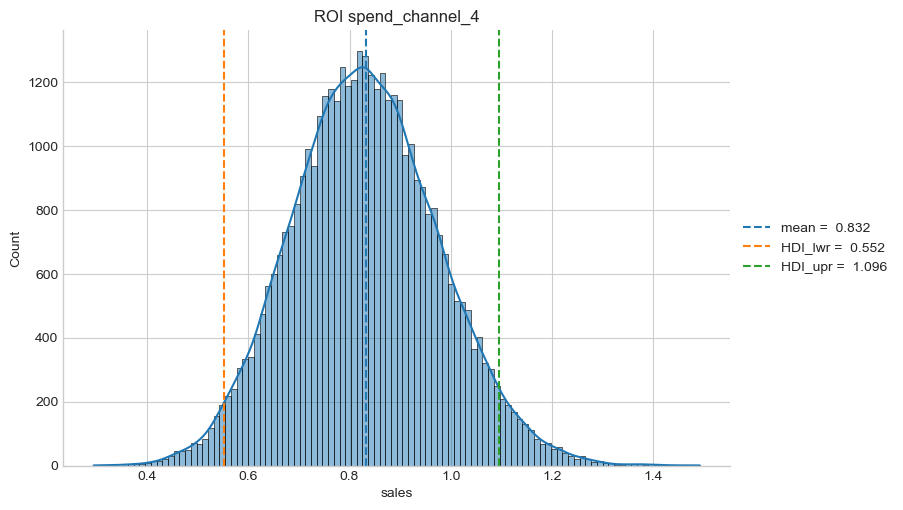

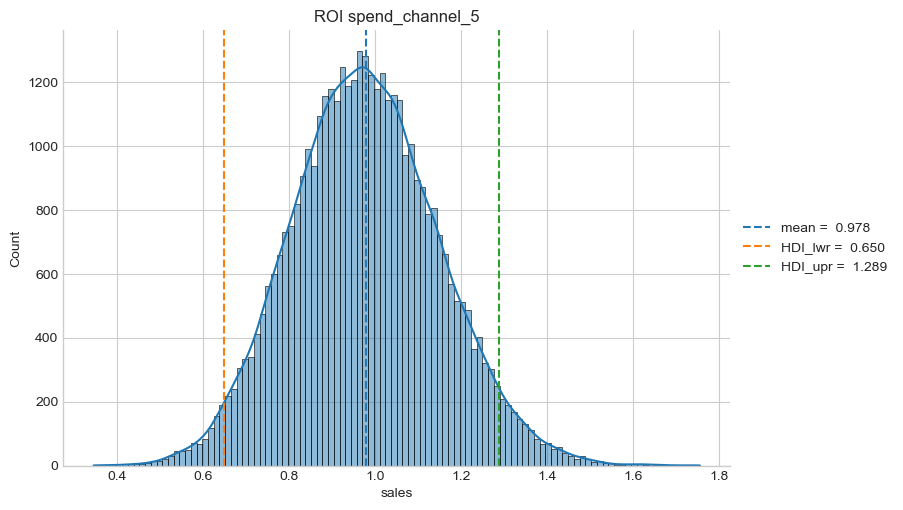

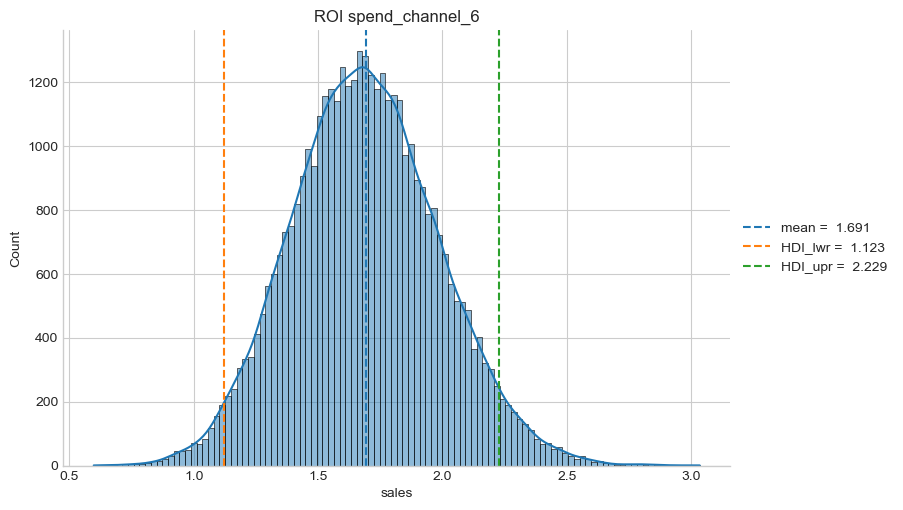

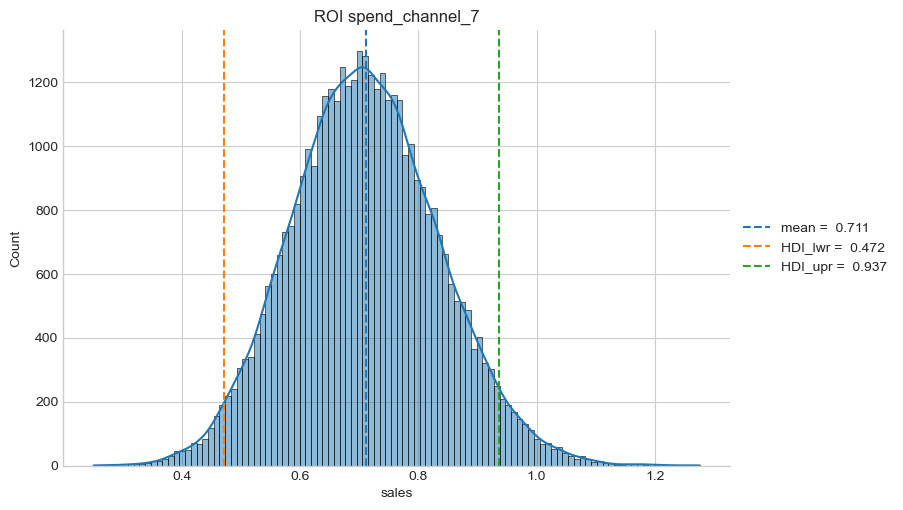

In [29]:
# The computation of the Return on Investment is a simplified version of the method proposed in Jin and Wang
# Instead of setting a channel to 0 for a speciffic interval within the simulation, each channel is shut to 0 throughout the entire horizon in turns
# The difference between the posterior distributions with all the channels and missing one channel is the numerator 
# The denominator is simply the total spend in the 7 channels

base_model_trace_roi = trace.copy()

for channel in var_list:

    with mmm:
        pm.set_data(new_data={f"{channel}_data": np.zeros_like(a=X[f'{channel}'])})
        base_model_trace_roi.extend(
            other=pm.sample_posterior_predictive(trace=base_model_trace_roi, var_names=["sales"])
        )
        
    base_roi_numerator = (
        az.extract(
                data=post_checks,
                group="posterior_predictive",
                var_names=["sales"],
            ) - az.extract(
                data=base_model_trace_roi,
                group="posterior_predictive",
                var_names=["sales"],
            )
        ).sum(axis=0)

    roi_denominator = data_stand[f"{channel}"].sum()

    base_roi = base_roi_numerator / roi_denominator        
 
    base_roi_mean = base_roi.mean()
    base_roi_hdi = az.hdi(ary=base_roi.values)

    g = sns.displot(x=base_roi, kde=True, height=5, aspect=1.5)
    ax = g.axes.flatten()[0]
    ax.axvline(
        x=base_roi_mean, color="C0", linestyle="--", label=f"mean = {base_roi_mean: 0.3f}"
    )
    ax.axvline(
        x=base_roi_hdi[0],
        color="C1",
        linestyle="--",
        label=f"HDI_lwr = {base_roi_hdi[0]: 0.3f}",
    )
    ax.axvline(
        x=base_roi_hdi[1],
        color="C2",
        linestyle="--",
        label=f"HDI_upr = {base_roi_hdi[1]: 0.3f}",
    )
    
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=f"ROI {channel}");

### comments 
The Return On Investment estimates are all above zero, confirming the assumption that all publicity is good publicity.<br>
Interestingly enough, some of the estimates contradict some of the assertions made before on this very section
Ordered by mean ROI, the channels from bottom to top performer are: 3, 7, 4, 5, 2, 6, 1!<br>
Apparently the return on investment for channel 1 is the best (more than twice the worst channel). The adstock permanence seems to be more relevant than the coefficient itself!